# Decision Variables Visualization

## Overview

This notebook provides visualization of decision variables (DV) extracted from neural spike data across multiple rats and sessions. The analysis focuses on how decision variables evolve over time for left vs right choice trials, with particular attention to session-level differences and temporal dynamics.

## Data Structure

- **Source**: Decision variables extracted from spike data using GLM analysis in `decision_variables_extraction_v003.ipynb`
- **Format**: HDF5 (.h5) files containing time-binned DV trajectories and trial metadata
- **Sessions**: Multiple behavioral sessions per rat, with focus on first and last sessions
- **Alignment**: All trajectories aligned to stimulus onset (clicks_on event)

## Visualization Strategy

**3×3 Grid Layout:**
- **Rows**: Individual rats (A324, A327, C211)
- **Columns**: 
  1. First session - early trials (trials 1 to split point)
  2. First session - late trials (remaining trials after split)
  3. Last available session

**Analysis Features:**
- Mean DV trajectories with SEM error bands
- Separate traces for left vs right choice trials
- Cross-session comparison to assess learning/adaptation
- Within-session comparison to examine trial-order effects

**Data Source:** `data/processed/` directory containing .h5 files from GLM extraction pipeline

## 1. Setup & Configuration

### Import Libraries and Set Parameters

In [71]:
# Section 1: Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# Configuration constants
DATA_DIR = Path("../../data/processed")

# Rat information and their specific split points
RATS = ['A324', 'A327', 'C211']
RAT_SPLIT_POINTS = {
    'A324': 240,
    'A327': 200,
    'C211': 100
}

print("Imports loaded with seaborn styling")
print(f"Data directory: {DATA_DIR}")
print(f"Rats to analyze: {RATS}")
print(f"Split points configured:")
for rat, split_point in RAT_SPLIT_POINTS.items():
    print(f"  {rat}: {split_point}")

Imports loaded with seaborn styling
Data directory: ../../data/processed
Rats to analyze: ['A324', 'A327', 'C211']
Split points configured:
  A324: 240
  A327: 200
  C211: 100


## 2. Data Loading Pipeline

### Functions for HDF5 Data Access

In [72]:
# Section 2: Data Loading Functions

def load_session_data(h5_file_path):
    """
    Load decision variables and trial data from a single .h5 file.
    
    Returns:
    - dv_df: DataFrame with decision variables data
    - trial_df: DataFrame with trial metadata including original_trial_num
    - metadata: Session metadata
    """
    try:
        # Load decision variables DataFrame
        dv_df = pd.read_hdf(h5_file_path, key='decision_variables')
        
        # Load trial DataFrame
        trial_df = pd.read_hdf(h5_file_path, key='trials')
        
        # Load metadata
        with h5py.File(h5_file_path, 'r') as f:
            metadata = {}
            if 'metadata' in f:
                for key in f['metadata'].keys():
                    if isinstance(f['metadata'][key], h5py.Dataset):
                        metadata[key] = f['metadata'][key][()]
                        if isinstance(metadata[key], bytes):
                            metadata[key] = metadata[key].decode('utf-8')
        
        # Extract date from directory name
        metadata['date'] = h5_file_path.parent.name
        
        print(f"Loaded {len(dv_df)} timepoints and {len(trial_df)} trials from {h5_file_path.name}")
        return dv_df, trial_df, metadata
    
    except Exception as e:
        print(f"Error loading {h5_file_path}: {e}")
        return None, None, None

def get_session_files(rat_id):
    """
    Get all session .h5 files for a given rat, sorted by date.
    
    Returns:
    - List of Path objects for .h5 files
    """
    rat_dir = DATA_DIR / rat_id
    if not rat_dir.exists():
        print(f"Directory not found: {rat_dir}")
        return []
    
    h5_files = []
    for session_dir in rat_dir.glob('*'):
        if session_dir.is_dir():
            h5_file = session_dir / f"{rat_id}_{session_dir.name}_session_data.h5"
            if h5_file.exists():
                h5_files.append(h5_file)
    
    # Sort by date (assuming format YYYY-MM-DD)
    h5_files.sort(key=lambda x: x.parent.name)
    
    return h5_files

# Test the loading functions
print("=== Testing Data Loading ===")
for rat in RATS:
    files = get_session_files(rat)
    print(f"{rat}: {len(files)} sessions found")
    if files:
        print(f"  First: {files[0].parent.name}")
        print(f"  Last: {files[-1].parent.name}")

=== Testing Data Loading ===
A324: 2 sessions found
  First: 2023-07-27
  Last: 2023-07-28
A327: 2 sessions found
  First: 2023-09-09
  Last: 2023-09-10
C211: 2 sessions found
  First: 2024-01-03
  Last: 2024-01-04


## 3. Data Organization & Session Splitting

### Prepare Data for 3×3 Grid Visualization

In [73]:
# Section 3: Data Organization

def organize_session_data():
    """
    Organize all session data for the 3x3 grid visualization.
    Uses rat-specific split points from RAT_SPLIT_POINTS dictionary.
    Now splits based on original_trial_num values.
    
    Returns:
    - Dictionary with organized data for each rat and session split
    """
    organized_data = {}
    
    for rat in RATS:
        print(f"\n=== Processing {rat} ===")
        files = get_session_files(rat)
        
        if len(files) == 0:
            print(f"No data files found for {rat}")
            continue
            
        # Get rat-specific split point
        rat_split_point = RAT_SPLIT_POINTS.get(rat, 500)  # Default to 500 if not specified
        print(f"Using original trial split point: {rat_split_point}")
            
        # Load first session (will be split)
        first_dv_df, first_trial_df, first_metadata = load_session_data(files[0])
        
        # Load last session
        if len(files) > 1:
            last_dv_df, last_trial_df, last_metadata = load_session_data(files[-1])
        else:
            last_dv_df, last_trial_df, last_metadata = first_dv_df.copy(), first_trial_df.copy(), first_metadata.copy()
        
        if first_dv_df is None or first_trial_df is None:
            continue
            
        # Join dv_df with trial_df to get original_trial_num
        first_dv_with_orig = first_dv_df.merge(first_trial_df[['trial_id', 'original_trial_num']], on='trial_id')
        
        # Check the range of original trial numbers
        min_orig_trial = first_dv_with_orig['original_trial_num'].min()
        max_orig_trial = first_dv_with_orig['original_trial_num'].max()
        print(f"  Original trial range: {min_orig_trial} to {max_orig_trial}")
        
        # Split based on original_trial_num instead of filtered trial_id
        first_part1 = first_dv_with_orig[first_dv_with_orig['original_trial_num'] <= rat_split_point].copy()
        first_part2 = first_dv_with_orig[first_dv_with_orig['original_trial_num'] > rat_split_point].copy()
        
        # Also join last session data
        last_dv_with_orig = last_dv_df.merge(last_trial_df[['trial_id', 'original_trial_num']], on='trial_id')
        
        # Count trials in each split
        part1_trials = first_part1['trial_id'].nunique()
        part2_trials = first_part2['trial_id'].nunique()
        total_trials = first_dv_with_orig['trial_id'].nunique()
        last_trials = last_dv_with_orig['trial_id'].nunique()
        
        organized_data[rat] = {
            'first_part1': first_part1,
            'first_part2': first_part2,
            'last_session': last_dv_with_orig,
            'metadata': {
                'first': first_metadata,
                'last': last_metadata
            },
            'split_info': {
                'total_trials': total_trials,
                'configured_split': rat_split_point,
                'original_trial_range': (min_orig_trial, max_orig_trial),
                'part1_trials': part1_trials,
                'part2_trials': part2_trials
            }
        }
        
        print(f"  Total filtered trials in first session: {total_trials}")
        print(f"  Original trial split point: {rat_split_point}")
        print(f"  Part 1 (orig_trial <= {rat_split_point}): {part1_trials} trials")
        print(f"  Part 2 (orig_trial > {rat_split_point}): {part2_trials} trials")
        print(f"  Last session: {last_trials} trials")
    
    return organized_data

# Load and organize all data
session_data = organize_session_data()
print(f"\nOrganized data for {len(session_data)} rats")


=== Processing A324 ===
Using original trial split point: 240
Loaded 17028 timepoints and 774 trials from A324_2023-07-27_session_data.h5
Loaded 11110 timepoints and 505 trials from A324_2023-07-28_session_data.h5
  Original trial range: 0 to 943
  Total filtered trials in first session: 774
  Original trial split point: 240
  Part 1 (orig_trial <= 240): 187 trials
  Part 2 (orig_trial > 240): 587 trials
  Last session: 505 trials

=== Processing A327 ===
Using original trial split point: 200
Loaded 12496 timepoints and 568 trials from A327_2023-09-09_session_data.h5
Loaded 8338 timepoints and 379 trials from A327_2023-09-10_session_data.h5
  Original trial range: 0 to 700
  Total filtered trials in first session: 568
  Original trial split point: 200
  Part 1 (orig_trial <= 200): 180 trials
  Part 2 (orig_trial > 200): 388 trials
  Last session: 379 trials

=== Processing C211 ===
Using original trial split point: 100
Loaded 7326 timepoints and 333 trials from C211_2024-01-03_session

In [74]:
session_data["A324"]["first_part1"]

,trial_id,time_bin_idx,time_bin,time_absolute,decision_variable,is_valid,model_accuracy,choice,rewarded,time_since_first_click,time_since_last_click,original_trial_num
0,0,0,-0.025,723.065688,-4.016726,True,0.659928,1,True,-0.045185,-0.333665,0
1,0,1,0.025,723.115688,-6.320940,True,0.665045,1,True,0.004815,-0.283665,0
2,0,2,0.075,723.165688,6.299604,True,0.719331,1,True,0.054815,-0.233665,0
3,0,3,0.125,723.215688,6.830590,True,0.785652,1,True,0.104815,-0.183665,0
4,0,4,0.175,723.265688,9.703870,True,0.806012,1,True,0.154815,-0.133665,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4109,186,17,0.825,3061.019183,7.758036,True,0.911977,1,True,0.816060,-0.016325,240
4110,186,18,0.875,3061.069183,4.900500,True,0.909408,1,True,0.866060,0.033675,240
4111,186,19,0.925,3061.119183,6.783902,True,0.910699,1,True,0.916060,0.083675,240
4112,186,20,0.975,3061.169183,4.825483,True,0.921476,1,True,0.966060,0.133675,240


## 4. Data Preparation & Visualization

### Prepare Data for Seaborn Grid Plotting

In [75]:
# Section 4: Data Preparation for Seaborn

def prepare_seaborn_data(session_data):
    """
    Prepare data in long format for seaborn visualization.
    
    Returns:
    - DataFrame with columns: time_bin, decision_variable, choice, rat, session_type
    """
    all_data = []
    
    # Get dates from the metadata for proper titles
    session_info = {}
    for rat in session_data:
        session_info[rat] = {
            'first_date': session_data[rat]['metadata']['first'].get('date', 'Unknown'),
            'last_date': session_data[rat]['metadata']['last'].get('date', 'Unknown')
        }
    
    session_mapping = {
        'first_part1': 'Early Trials',
        'first_part2': 'Late Trials', 
        'last_session': 'Last Session'
    }
    
    choice_mapping = {0: 'Left', 1: 'Right'}
    
    for rat in session_data:
        for session_key, session_label in session_mapping.items():
            dv_df = session_data[rat][session_key]
            
            # Add categorical columns for faceting
            dv_df_copy = dv_df.copy()
            dv_df_copy['rat'] = rat
            dv_df_copy['session_type'] = session_label
            dv_df_copy['choice_label'] = dv_df_copy['choice'].map(choice_mapping)
            
            # Add date information for titles
            if session_key in ['first_part1', 'first_part2']:
                dv_df_copy['date'] = session_info[rat]['first_date']
            else:
                dv_df_copy['date'] = session_info[rat]['last_date']
            
            # Select relevant columns
            plot_data = dv_df_copy[['time_bin', 'decision_variable',
                                     'choice_label', 'rat', 'session_type', 'date', 'trial_id', 'choice']].copy()

            all_data.append(plot_data)
    
    # Combine all data
    combined_df = pd.concat(all_data, ignore_index=True)
    
    print(f"Prepared seaborn data: {len(combined_df)} rows")
    print(f"  Rats: {combined_df['rat'].unique()}")
    print(f"  Sessions: {combined_df['session_type'].unique()}")
    print(f"  Choices: {combined_df['choice_label'].unique()}")
    
    return combined_df

# Prepare data for seaborn visualization
if session_data:
    plot_df = prepare_seaborn_data(session_data)
    print(f"Data prepared for visualization")
else:
    print("No session data available")

Prepared seaborn data: 65340 rows
  Rats: ['A324' 'A327' 'C211']
  Sessions: ['Early Trials' 'Late Trials' 'Last Session']
  Choices: ['Right' 'Left']
Data prepared for visualization


## 5. Seaborn Grid Visualization

### Modern 3×3 Grid with Automatic Statistics

In [76]:
session_data["A324"]["first_part1"]

,trial_id,time_bin_idx,time_bin,time_absolute,decision_variable,is_valid,model_accuracy,choice,rewarded,time_since_first_click,time_since_last_click,original_trial_num
0,0,0,-0.025,723.065688,-4.016726,True,0.659928,1,True,-0.045185,-0.333665,0
1,0,1,0.025,723.115688,-6.320940,True,0.665045,1,True,0.004815,-0.283665,0
2,0,2,0.075,723.165688,6.299604,True,0.719331,1,True,0.054815,-0.233665,0
3,0,3,0.125,723.215688,6.830590,True,0.785652,1,True,0.104815,-0.183665,0
4,0,4,0.175,723.265688,9.703870,True,0.806012,1,True,0.154815,-0.133665,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4109,186,17,0.825,3061.019183,7.758036,True,0.911977,1,True,0.816060,-0.016325,240
4110,186,18,0.875,3061.069183,4.900500,True,0.909408,1,True,0.866060,0.033675,240
4111,186,19,0.925,3061.119183,6.783902,True,0.910699,1,True,0.916060,0.083675,240
4112,186,20,0.975,3061.169183,4.825483,True,0.921476,1,True,0.966060,0.133675,240


In [77]:
def calculate_choice_proportions(plot_df, rat, session_type):
    total_number_trials = plot_df[(plot_df.rat == rat) & 
                                  (plot_df.session_type == session_type)]["trial_id"].nunique()

    right_trials = plot_df[(plot_df.rat == rat) &
                           (plot_df.session_type == session_type)].choice.sum() / plot_df.time_bin.nunique()
    
    left_trials = total_number_trials - right_trials

    return right_trials, left_trials

=== Creating Seaborn 3x3 Grid ===


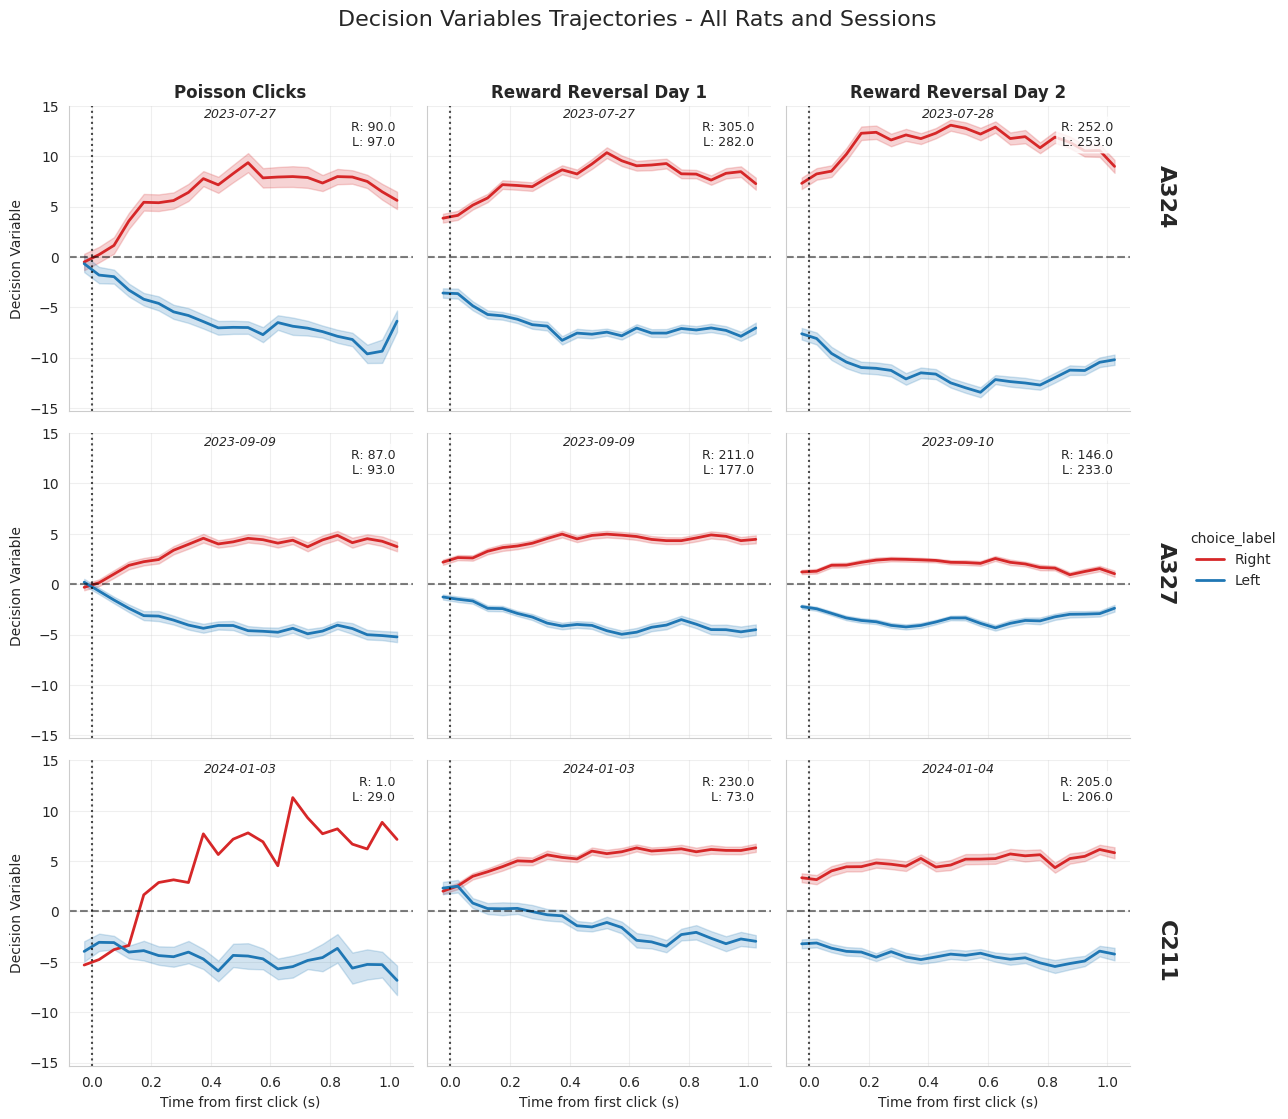

Seaborn grid visualization created!

=== Data Summary ===
choice_label       Left  Right
rat  session_type             
A324 Early Trials  2134   1980
     Last Session  5566   5544
     Late Trials   6204   6710
A327 Early Trials  2046   1914
     Last Session  5126   3212
     Late Trials   3894   4642
C211 Early Trials   638     22
     Last Session  4532   4510
     Late Trials   1606   5060


In [78]:
# Section 5: Seaborn Grid Visualization

def create_seaborn_grid(plot_df):
    """
    Create 3x3 grid using seaborn's relplot for clean, automatic visualization.
    """
    # Set custom color palette for left/right choices
    colors = ['#d62728', '#1f77b4']  # Red for left, blue for right
    
    # Create the relplot grid
    g = sns.relplot(
        data=plot_df,
        x='time_bin', 
        y='decision_variable',
        hue='choice_label',
        hue_order=['Right', 'Left'],
        row='rat', 
        col='session_type',
        kind='line',
        estimator='mean',
        errorbar='se',  # Standard error
        height=4,
        aspect=1.0,
        palette=colors,
        linewidth=2,
        facet_kws={'margin_titles': True}
    )
    
    # Set proper axis labels
    g.set_axis_labels('Time from first click (s)', 'Decision Variable')
    
    # Keep the big column titles but customize them
    g.set_titles(col_template='', row_template='')
    custom_titles = ['Poisson Clicks', 'Reward Reversal Day 1', 'Reward Reversal Day 2']
    for i, title in enumerate(custom_titles):
        g.axes[0, i].set_title(title, fontsize=12, fontweight='bold')

    # Add rat names on the right side - horizontal and larger
    for i, rat in enumerate(['A324', 'A327', 'C211']):
        # Add rat name as text on the right side of the rightmost subplot
        ax = g.axes[i, -1]  # rightmost subplot in each row
        g.fig.text(0.9, ax.get_position().y0 + ax.get_position().height/2, rat, 
                   fontsize=16, fontweight='bold', rotation=-90, 
                   ha='left', va='center')
    
    # Add date mini-titles and choice counts to each subplot
    for i, rat in enumerate(['A324', 'A327', 'C211']):
        for j, session_type in enumerate(['Early Trials', 'Late Trials', 'Last Session']):
            ax = g.axes[i, j]
            
            # Get subset of data for this specific subplot
            subplot_data = plot_df[(plot_df['rat'] == rat) & (plot_df['session_type'] == session_type)]
            
            if not subplot_data.empty:
                # Get date for this subplot
                date = subplot_data['date'].iloc[0]
                
                # Actually count from the original session data to get accurate trial counts
                if rat in session_data:
                    right_count, left_count = calculate_choice_proportions(plot_df, rat, session_type)

                else:
                    left_count = right_count = 0
                
                # Add date as mini-title below the main column title
                ax.text(0.5, 0.95, date, transform=ax.transAxes, 
                       ha='center', va='bottom', fontsize=9, style='italic')
                
                # Add choice counts as text annotation in top right
                count_text = f"R: {right_count}\nL: {left_count}"
                ax.text(0.95, 0.95, count_text, transform=ax.transAxes, 
                       ha='right', va='top', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Add reference lines to each subplot
    for ax in g.axes.flat:
        ax.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax.axvline(0, color='black', linestyle=':', alpha=0.7)
        ax.grid(True, alpha=0.3)
    
    # Overall title
    g.fig.suptitle('Decision Variables Trajectories - All Rats and Sessions', 
                   fontsize=16, y=0.98)
    
    # Adjust layout to accommodate rat names on right
    g.fig.subplots_adjust(top=0.90, right=0.88, bottom=0.1)
    
    return g

# Create the seaborn visualization
print("=== Creating Seaborn 3x3 Grid ===")

if 'plot_df' in locals() and len(plot_df) > 0:
    seaborn_grid = create_seaborn_grid(plot_df)
    plt.show()
    print("Seaborn grid visualization created!")
    
    # Summary statistics  
    print("\n=== Data Summary ===")
    summary = plot_df.groupby(['rat', 'session_type', 'choice_label']).size().unstack(fill_value=0)
    print(summary)
    
else:
    print("Plot data not available - run previous cells first")